# Transfer Learning - MobileNet

Mount Drive if on Colab

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [3]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px

## Unzip the data

Unzip the dataset if on Colab

In [4]:
# !unzip -qu '/content/drive/MyDrive/Colab Notebooks/EEAI/Project/ASL Alphabet/ASL.zip' -d 'data'
# !unzip -qu '/content/drive/MyDrive/Colab Notebooks/EEAI/Project/ASL Alphabet/ASL Real.zip' -d 'data'

## Load the data

In [5]:
train_path = 'data/asl_alphabet_train/asl_alphabet_train'
test_path = 'data/asl_alphabet_test/asl_alphabet_test'
real_path = 'data/asl_alphabet_real/asl_alphabet_real'

In [6]:
class_labels = os.listdir(train_path)
class_mapping = {i:label for i, label in enumerate(class_labels)}

## Train-validation split

In [7]:
split_threshold = 0.2
batch_size = 32

In [8]:
train_ds, validation_ds = keras.utils.image_dataset_from_directory(train_path, batch_size=batch_size, validation_split=split_threshold, subset='both', seed=42, class_names=class_labels)

Found 87000 files belonging to 29 classes.
Using 69600 files for training.
Using 17400 files for validation.


In [9]:
test_ds = keras.utils.image_dataset_from_directory(real_path, batch_size=batch_size)

Found 870 files belonging to 29 classes.


In [10]:
print('Number of train batches: %d' % tf.data.experimental.cardinality(train_ds))
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_ds))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_ds))

Number of train batches: 2175
Number of validation batches: 544
Number of test batches: 28


## Pre-processing

Enable prefetching to increase performance

In [11]:
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
validation_ds = validation_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

In [12]:
img_shape = (256, 256, 3)
border_width = 8
num_classes = 29

Crop to remove the blue border in the train and in the validation sets

In [13]:
def crop(image, label):
    ratio = (image.shape[1] - border_width) / image.shape[1]
    cropped_img = tf.image.central_crop(image, ratio)
    return cropped_img, label

In [14]:
train_ds = train_ds.map(crop, num_parallel_calls=tf.data.AUTOTUNE)
validation_ds = validation_ds.map(crop, num_parallel_calls=tf.data.AUTOTUNE)

Check that in all sets the classes are balanced

In [15]:
def plot_class_distribution(dataset, y_lim):
    labels = np.concatenate([y for x, y in dataset], axis=0)
    labels_str = np.array([class_mapping[i] for i in labels])
    fig = px.histogram(x=labels_str)
    fig.update_layout(
        title_text='Class distribution',
        xaxis_title_text='Class name',
        yaxis_title_text='Count',
        bargap=0.5,
        yaxis_range=[0, y_lim]
    )
    fig.show()

In [16]:
plot_class_distribution(train_ds, 3100)

In [17]:
plot_class_distribution(validation_ds, 3100)

In [18]:
plot_class_distribution(test_ds, 50)

Visualize the first 9 images

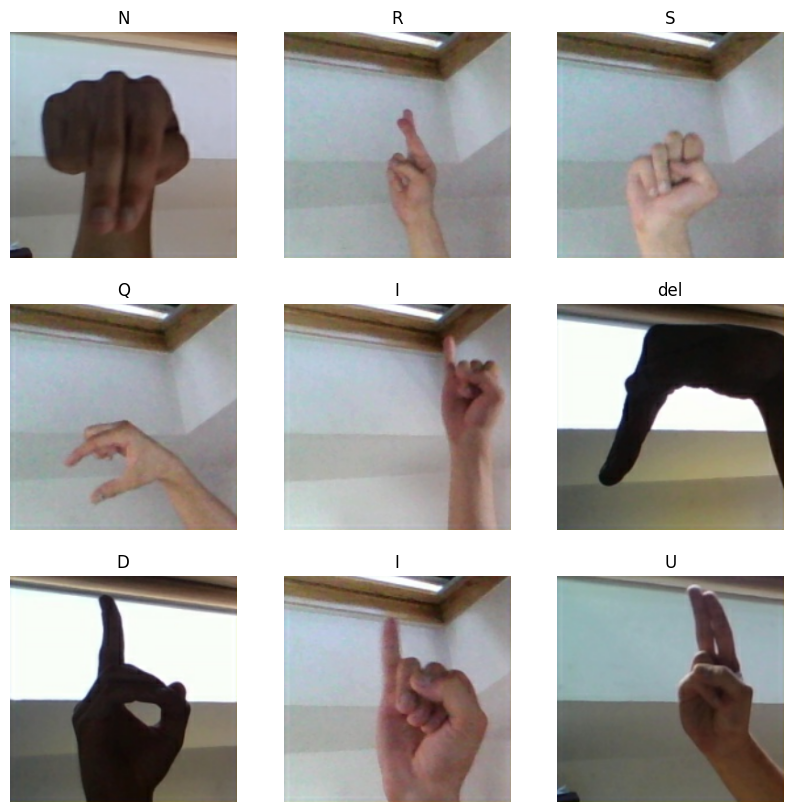

In [19]:
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.unbatch().take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype('uint8'))
    plt.title(class_mapping[int(label)])
    plt.axis("off")

Data augmentation policy

In [20]:
# def augment_image(image, label):
#     # Flips the image randomly
#     image = tf.image.random_flip_left_right(image)
#
#     # Increase the image size, then randomly crop it down to
#     # the original dimensions
#     resize_factor = random.uniform(1, 1.2)
#     new_height = math.floor(resize_factor * INPUT_SHAPE[0])
#     new_width = math.floor(resize_factor * INPUT_SHAPE[1])
#     image = tf.image.resize_with_crop_or_pad(image, new_height, new_width)
#     image = tf.image.random_crop(image, size=INPUT_SHAPE)
#
#     # Vary the brightness of the image
#     image = tf.image.random_brightness(image, max_delta=0.2)
#
#     return image, label

In [21]:
# train_dataset = train_dataset.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)
# train_dataset.element_spec

In [22]:
print('Number of train batches: %d' % tf.data.experimental.cardinality(train_ds))
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_ds))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_ds))

Number of train batches: 2175
Number of validation batches: 544
Number of test batches: 28


Check again that classes are balanced after augmentation

In [23]:
# plot_class_distribution(train_ds, 3100)

In [24]:
# plot_class_distribution(validation_ds, 3100)

In [25]:
# plot_class_distribution(test_ds, 100)

## Transfer Learning with MobileNetV1

In [26]:
def check_accuracy(_, logs):
  if logs.get('val_accuracy') >= 0.99:
    model.stop_training = True

In [27]:
callbacks = [
    keras.callbacks.EarlyStopping(
      monitor="val_loss",
      min_delta=0.01,
      patience=10,
      restore_best_weights=True,
      verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
      monitor="val_accuracy",
      min_delta=0.01,
      factor=0.1,
      patience=3,
      min_lr=1e-7,
      verbose=1
    ),
    keras.callbacks.LambdaCallback(
      on_epoch_end=check_accuracy
    ),
    keras.callbacks.TerminateOnNaN()
]

In [28]:
img_shape_resized = (96, 96, 3)

In [29]:
weights_path = 'weights/MobileNetV1.0_2.96x96.color.bsize_96.lr_0_05.epoch_170.val_loss_3.61.val_accuracy_0.27.hdf5'

Load the weights of MobileNetV1 pre-trained on the ImageNet dataset with 96x96 images.
The weights are downloaded from Edge Impulse.

In [30]:
base_model = tf.keras.applications.MobileNet(
    weights = weights_path,
    alpha=0.2,
    depth_multiplier=1,
    input_shape=img_shape_resized
)

In [31]:
base_model.summary()

Model: "mobilenet_0.20_96"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 conv1 (Conv2D)              (None, 48, 48, 6)         162       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 48, 48, 6)        24        
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 48, 48, 6)         0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 48, 48, 6)        54        
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 48, 48, 6)        24        
 ation)                                          

We need to manually remove the classification head (last 5 layers):

In [32]:
base_model = keras.Sequential(base_model.layers[:-5], name=base_model.name)
base_model.summary()

Model: "mobilenet_0.20_96"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 48, 48, 6)         162       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 48, 48, 6)        24        
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 48, 48, 6)         0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 48, 48, 6)        54        
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 48, 48, 6)        24        
 ation)                                                          
                                                                 
 conv_dw_1_relu (ReLU)       (None, 48, 48, 6)   

In [33]:
base_model.trainable = False

Build the final model

In [34]:
model = keras.Sequential([
    # Input layer
    keras.Input(shape=(None, None, 3), name='first_layer'),
    # Resizing layer
    keras.layers.Resizing(96, 96, name='resize'),
    # Pre-processing for MobileNetV1
    keras.layers.Lambda(tf.keras.applications.mobilenet.preprocess_input, name='preprocessing'),
    # MobileNetV1
    base_model,
    # Convert tensors to vectors
    keras.layers.GlobalAveragePooling2D(name='pooling'),
    # Fully-connected classifier
    keras.layers.Dense(num_classes, name='classifier')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resize (Resizing)           (None, 96, 96, 3)         0         
                                                                 
 preprocessing (Lambda)      (None, 96, 96, 3)         0         
                                                                 
 mobilenet_0.20_96 (Sequenti  (None, 3, 3, 204)        142259    
 al)                                                             
                                                                 
 pooling (GlobalAveragePooli  (None, 204)              0         
 ng2D)                                                           
                                                                 
 classifier (Dense)          (None, 29)                5945      
                                                                 
Total params: 148,204
Trainable params: 5,945
Non-traina

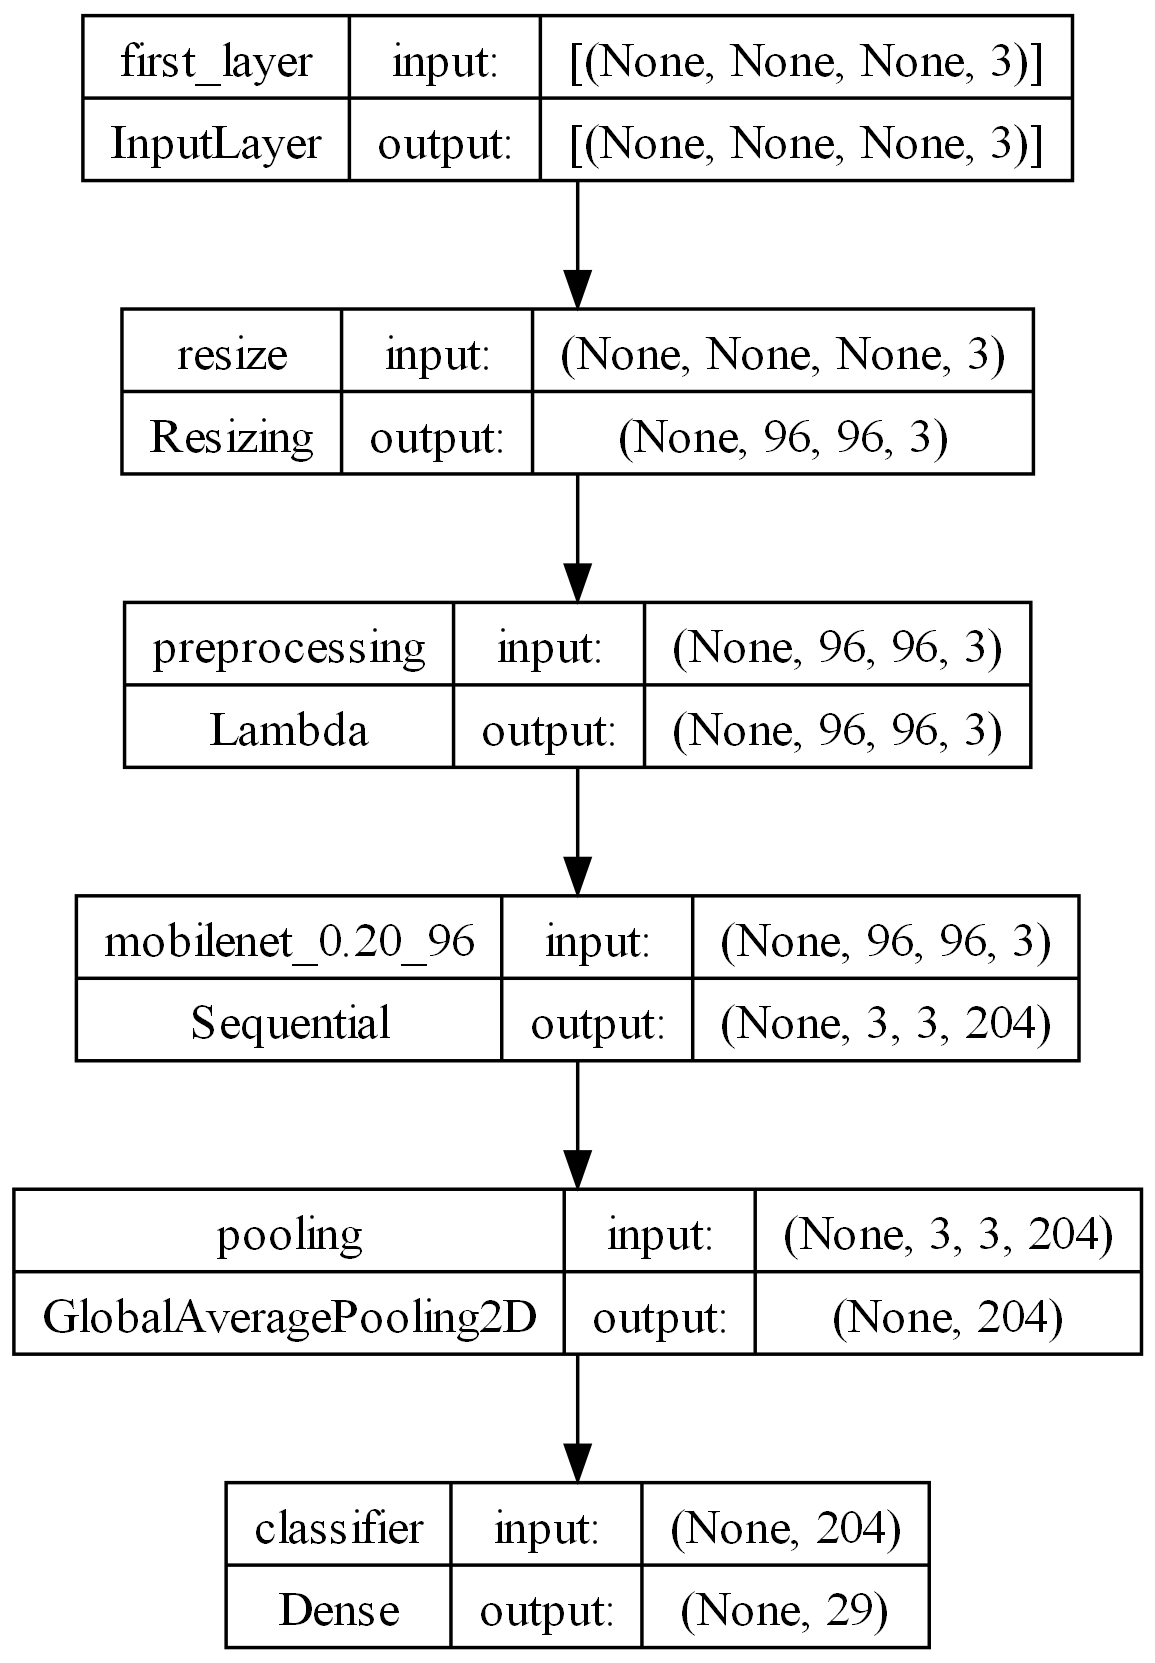

In [35]:
keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True, dpi=250)

In [36]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [37]:
history = model.fit(train_ds, epochs=50, validation_data=validation_ds, callbacks=callbacks)

Epoch 1/50
2175/2175 [==============================] - 48s 20ms/step - loss: 1.3904 - accuracy: 0.6415 - val_loss: 0.8276 - val_accuracy: 0.7870 - lr: 0.0010
Epoch 2/50
2175/2175 [==============================] - 48s 22ms/step - loss: 0.6854 - accuracy: 0.8228 - val_loss: 0.5957 - val_accuracy: 0.8386 - lr: 0.0010
Epoch 3/50
2175/2175 [==============================] - 49s 22ms/step - loss: 0.5236 - accuracy: 0.8622 - val_loss: 0.4793 - val_accuracy: 0.8710 - lr: 0.0010
Epoch 4/50
2175/2175 [==============================] - 41s 19ms/step - loss: 0.4387 - accuracy: 0.8831 - val_loss: 0.4172 - val_accuracy: 0.8864 - lr: 0.0010
Epoch 5/50
2175/2175 [==============================] - 41s 19ms/step - loss: 0.3854 - accuracy: 0.8966 - val_loss: 0.3764 - val_accuracy: 0.8956 - lr: 0.0010
Epoch 6/50
2175/2175 [==============================] - 50s 23ms/step - loss: 0.3475 - accuracy: 0.9065 - val_loss: 0.3439 - val_accuracy: 0.9002 - lr: 0.0010
Epoch 7/50
2175/2175 [========================

(0.626273000240326, 1.0)

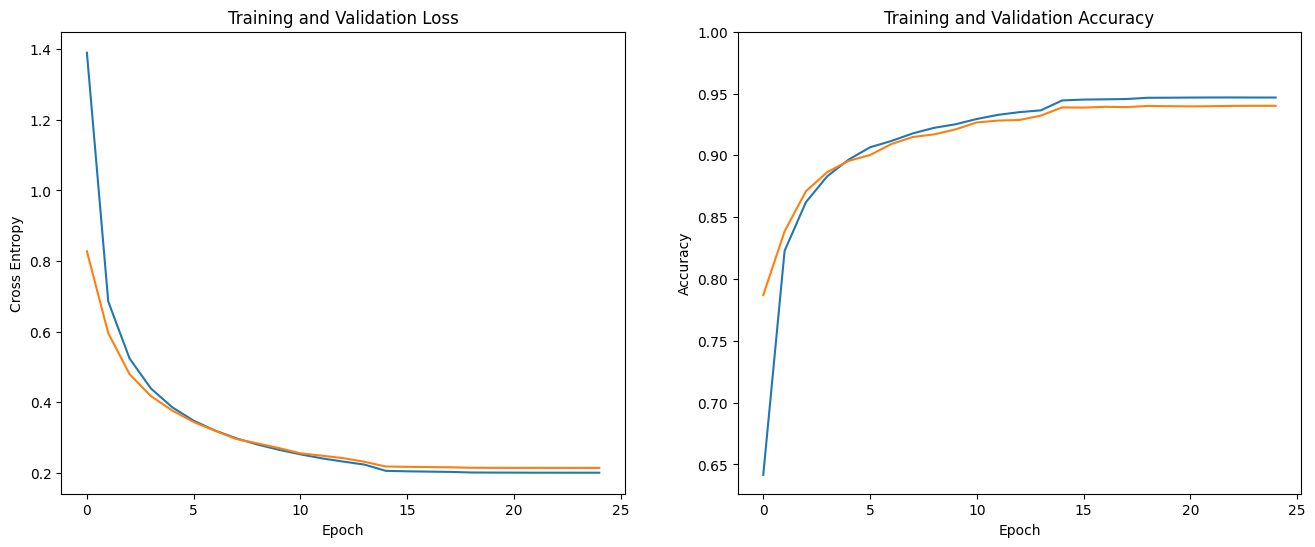

In [38]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy')
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')

plt.subplot(1, 2, 2)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([min(plt.ylim()),1])

In [39]:
# loss, accuracy = model.evaluate(test_ds)
# print('Test accuracy:', accuracy)

## Fine-tuning the whole network

In [40]:
# Unfreeze the base model
base_model.trainable = True

In [41]:
# Recompile the model to apply the changes
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-5), # low learning rate
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_ds, epochs=30, validation_data=validation_ds, callbacks=callbacks)

Epoch 1/30
2175/2175 [==============================] - 74s 33ms/step - loss: 5.0054 - accuracy: 0.4645 - val_loss: 1.5820 - val_accuracy: 0.6845 - lr: 1.0000e-05
Epoch 2/30
2175/2175 [==============================] - 59s 27ms/step - loss: 1.3021 - accuracy: 0.7166 - val_loss: 0.6755 - val_accuracy: 0.8173 - lr: 1.0000e-05
Epoch 3/30
2175/2175 [==============================] - 69s 31ms/step - loss: 0.7330 - accuracy: 0.8062 - val_loss: 0.4097 - val_accuracy: 0.8789 - lr: 1.0000e-05
Epoch 4/30
2175/2175 [==============================] - 64s 29ms/step - loss: 0.5030 - accuracy: 0.8532 - val_loss: 0.2810 - val_accuracy: 0.9110 - lr: 1.0000e-05
Epoch 5/30
2175/2175 [==============================] - 62s 29ms/step - loss: 0.3733 - accuracy: 0.8840 - val_loss: 0.2078 - val_accuracy: 0.9317 - lr: 1.0000e-05
Epoch 6/30
2175/2175 [==============================] - 69s 31ms/step - loss: 0.2930 - accuracy: 0.9052 - val_loss: 0.1618 - val_accuracy: 0.9456 - lr: 1.0000e-05
Epoch 7/30
2175/2175 [

(0.43822270184755324, 1.0)

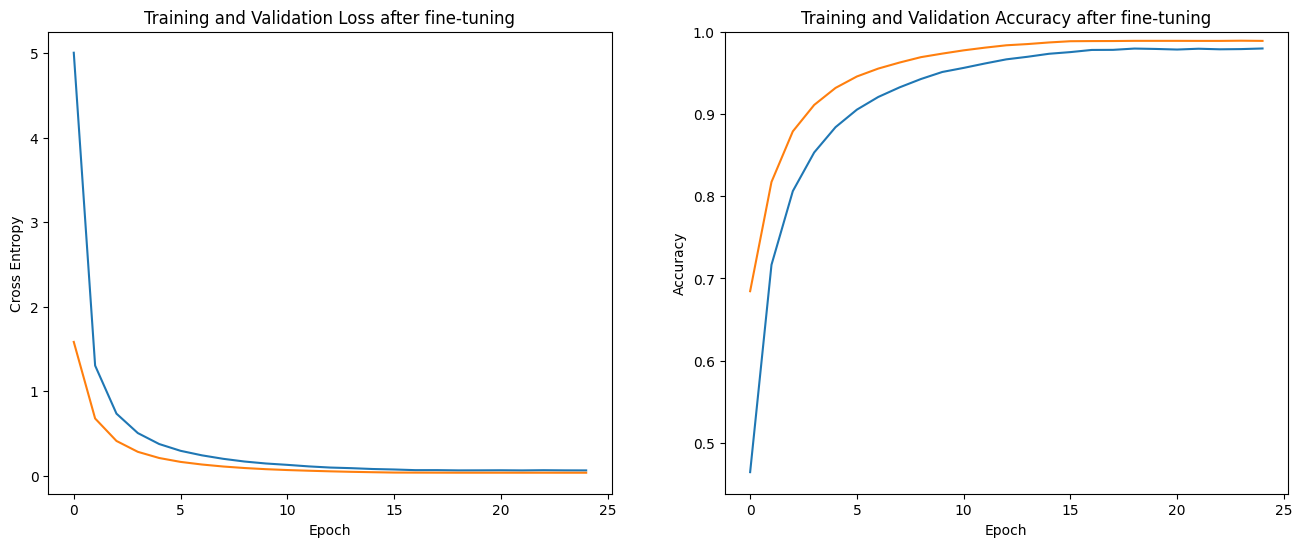

In [54]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.title('Training and Validation Loss after fine-tuning')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy')
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')

plt.subplot(1, 2, 2)
plt.title('Training and Validation Accuracy after fine-tuning')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([min(plt.ylim()),1])

In [65]:
model.save('models/asl_mobilenet_tuned', save_format='h5')

# Evaluation

Confusion matrix on the validation set

In [56]:
true_labels = np.array([])
pred_labels = np.array([])
for batch in validation_ds:
  # Tuple unpacking
  images, t_labels = batch

  # Compute new labels
  p_labels = model.predict_on_batch(images)
  p_labels = np.argmax(p_labels, axis=1)

  # Concatenate in a single vector
  true_labels = np.concatenate([true_labels, t_labels])
  pred_labels = np.concatenate([pred_labels, p_labels])

In [57]:
from sklearn import metrics
cm = metrics.confusion_matrix(true_labels, pred_labels)

In [58]:
size = 1000
px.imshow(cm, x=class_labels, y=class_labels, text_auto=True, width=size, height=size, color_continuous_scale='blues')

How many errors per class?

In [59]:
total_errors = cm.sum(axis=1) - np.max(cm, axis=1)
fig = px.bar(x=class_labels, y=total_errors, orientation='v')
fig.update_layout(
    title_text='Total miss-classifications per class',
    xaxis_title_text='Class name',
    yaxis_title_text='Count',
    bargap=0.3,
)

Compute now the relative error

In [60]:
total_samples = cm.sum(axis=1)
relative_errors = total_errors / total_samples
fig = px.bar(x=class_labels, y=relative_errors, orientation='v')
fig.update_layout(
    title_text='Percentage of miss-classifications per class',
    xaxis_title_text='Class name',
    yaxis_title_text='Count',
    bargap=0.3,
)

Predictions:
 ['T' 'A' 'space' 'I' 'Q' 'X' 'H' 'nothing' 'W' 'W' 'P' 'O' 'G' 'O' 'N' 'R'
 'Q' 'N' 'L' 'A' 'C' 'M' 'C' 'X' 'L' 'del' 'B' 'T' 'U' 'G' 'N' 'I']
Labels:
 ['T' 'A' 'space' 'I' 'Q' 'X' 'H' 'nothing' 'W' 'W' 'P' 'O' 'G' 'O' 'N' 'R'
 'Q' 'N' 'L' 'A' 'C' 'M' 'C' 'X' 'L' 'del' 'B' 'T' 'U' 'G' 'N' 'I']


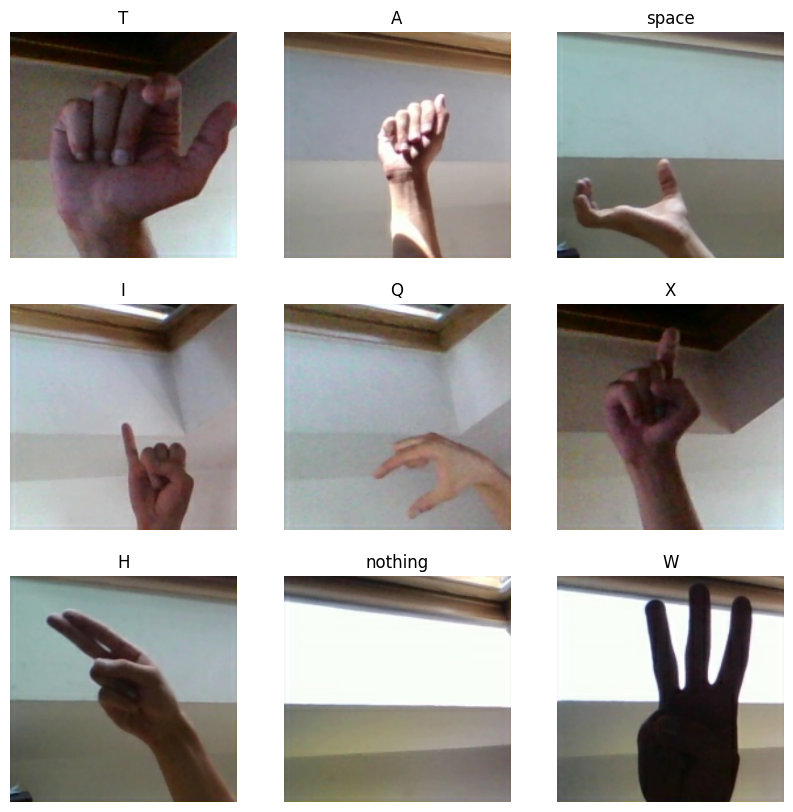

In [61]:
# Retrieve a batch of images from the validation set
image_batch, label_batch = validation_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)

# Apply a softmax since our model returns logits
predictions = tf.nn.softmax(predictions)
predictions = tf.argmax(predictions, axis=1)

# Convert indexes to class names
label_batch = np.array([class_mapping[i] for i in label_batch])
predictions = np.array([class_mapping[i] for i in predictions.numpy()])

print('Predictions:\n', predictions)
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(predictions[i])
  plt.axis("off")

Evaluation on the test set

In [62]:
# loss, accuracy = model.evaluate(test_ds)
# print('Test accuracy:', accuracy)

Confusion matrix on the test set

In [63]:
# true_labels = np.array([])
# pred_labels = np.array([])
# for batch in test_ds:
#   # Tuple unpacking
#   images, t_labels = batch
#
#   # Compute new labels
#   p_labels = model.predict_on_batch(images)
#   p_labels = np.argmax(p_labels, axis=1)
#
#   # Concatenate in a single vector
#   true_labels = np.concatenate([true_labels, t_labels])
#   pred_labels = np.concatenate([pred_labels, p_labels])
#
# cm = metrics.confusion_matrix(true_labels, pred_labels)
# px.imshow(cm, x=class_labels, y=class_labels, text_auto=True, width=size, height=size, color_continuous_scale='blues')

Relative error on the test set

In [64]:
# total_errors = cm.sum(axis=1) - np.max(cm, axis=1)
# total_samples = cm.sum(axis=1)
# relative_errors = total_errors / total_samples
# fig = px.bar(x=class_labels, y=relative_errors, orientation='v')
# fig.update_layout(
#     title_text='Percentage of miss-classifications per class',
#     xaxis_title_text='Class name',
#     yaxis_title_text='Count',
#     bargap=0.3,
# )